# Train LSTM network using Keypoint Features

## Import libraries

In [1]:
# Basic functions
import os
import torch
import numpy as np
import re
from importlib import reload

# Training/Test Set Creation - to use later
from sklearn.model_selection import StratifiedShuffleSplit

# Dataset Creation
from collections import Counter
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize

# Model Training and Definition
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
import trainutils
import vidutils

## Create Training and Test Sets

### Load training data
Choose between using synthetic data, real data or both. 

Usage example: If only real data is to be used, set `real_data` to `True` and `syn_data` to `False`.

In [2]:
X_paths = [] # paths of segment folders
y = [] # designated label

# Specify directories
frame_folder = "./data/frames"

# Construct X = folder names, y = the label
vf_list = []
for f in os.listdir(frame_folder):
    if not f.startswith('.'):
        vf_list.append(f)

for vf_folder in vf_list:
    # Create path to video
    vf_path = os.path.join(frame_folder, vf_folder)
    print("Current Video: "+ vf_folder)

    # Get individual segment folder
    segfolder_list = os.listdir(vf_path)

    # Check every segment folder
    for seg_folder in segfolder_list:

        if not seg_folder.startswith('.'):
            x_path = os.path.join(vf_path, seg_folder)
            X_paths.append(x_path + '/features.npz')

            # Extract class label from folder name
            label = int(seg_folder.split("_")[2])
            y.append(label)

Current Video: video1
Current Video: video2
Current Video: video3
Current Video: video4


In [3]:
# Preview Data distribution
from collections import Counter
Counter(y)

Counter({1: 54, 2: 49, 4: 50, 5: 51, 8: 52, 9: 52, 0: 48, 3: 50, 6: 48, 7: 50})

In [4]:
# Split into training and test sets
splitter = StratifiedShuffleSplit(n_splits = 2, test_size = 0.1, random_state = 0)
train_set, test_set = next(splitter.split(X_paths, y))

# Training Set
train_X_paths = [X_paths[i] for i in train_set]
train_ys = [y[i] for i in train_set]
print("Training Set: ({0},{1})".format(len(train_X_paths), len(train_ys)))

# Test Set
test_X_paths = [X_paths[i] for i in test_set]
test_ys = [y[i] for i in test_set]
print("Test Set: ({0},{1})".format(len(test_X_paths), len(test_ys)))
#print(test_X_paths)

Training Set: (453,453)
Test Set: (51,51)


### Conversion to Pytorch Dataset
Set seeds for reproducibility and produce pytorch tensor for training.

In [5]:
# Set seeds for reproducibility
np.random.seed(4139)
torch.manual_seed(4139)

Definition of dataset class and normalization function

In [6]:
# Define Dataset Class
class SyncDataset(Dataset):
    
    def __init__(self, X, y, transform=None):
        self.transform = transform
        self.X = X
        self.y = y
    
    # Returns length
    def __len__(self):
        return len(self.X)
    
    # Returns X feature array and y value
    def __getitem__(self, idx):
        
        # Load npz file
        npz_path = self.X[idx]
        data = np.load(npz_path)
        num_frames = 20
        
        # extract features (different based on synthetic or real)
        if npz_path.startswith('./data/'):
            X_feat = data['feature_array']
        else:
            X_feat = vidutils.reshape_syn_features \
            (data['subset_all'][:num_frames], data['candidate_all'][:num_frames])
        
         # apply transform
        if self.transform:
            X_tensor = self.transform(X_feat).squeeze().float()
        else:
            # Convert X to tensor
            X_tensor = torch.from_numpy(X_feat).float()
        
        return X_tensor, self.y[idx] # y_tensor

# Define normalization function
class norm_with_saved(object):
    """
    Rescale each feature by subtracting mean and dividing by SD over all subjects
    IMPORTANT: Calculate saved_mean and saved_std first.
    """
    def __call__(self, sample):
        # squeeze tensor
        sample = sample.squeeze()
        # normalize
        scaled_sample = (sample - saved_mean)/saved_std
        return scaled_sample

In [7]:
# precalculate means and std
dataset = []
training_dataset = SyncDataset(X = train_X_paths, y = train_ys)
for train_X, train_y in training_dataset:
    new_row = train_X.data.numpy()
    if len(dataset) == 0:
        dataset = new_row
    else:
        dataset = np.vstack((dataset,new_row))
saved_mean = np.mean(dataset, axis=0) 
saved_std = np.std(dataset, axis=0) 
saved_std[saved_std == 0] = 0.00001 # prevent error dividing by 0

# Define Transformer
transformer = transforms.Compose([
    norm_with_saved(),
    transforms.ToTensor()
])

In [8]:
# Define Training Dataset 
training_dataset = SyncDataset(X = train_X_paths, y = train_ys, transform = transformer)
print(len(training_dataset))

# Define Test Dataset
testing_dataset = SyncDataset(X = test_X_paths, y = test_ys, transform = transformer)
print(len(testing_dataset))

453
51


In [9]:
# Grab a row to see contents
sample_X, sample_y = training_dataset[2]
sample_X.shape, sample_y

(torch.Size([20, 168]), 6)

## Define Data Loader  
Data Loader for extracting batches from the Pytorch Dataset during model training

In [10]:
def batch_collater(batch):
    X_batch, y_batch = list(zip(*batch))
    
    # Separate batch into X and y
    X_batch = [x for x in X_batch if len(x) > 0]
    y_batch = [torch.tensor(y) for y, x in zip(y_batch, X_batch) if len(x) > 0]
    
    # Convert into tensors
    X_tensor = torch.stack(X_batch)
    y_tensor = torch.stack(y_batch).long()
    
    return X_tensor, y_tensor

In [11]:
# Specify batch size
batch_size = 30

training_loader = DataLoader(training_dataset, batch_size = batch_size, shuffle=True, collate_fn=batch_collater)
testing_loader = DataLoader(testing_dataset, batch_size = batch_size, shuffle=True, collate_fn=batch_collater)

# check shapes
for xb, yb in training_loader:
    print(xb.shape, yb.shape)
    break

for xb, yb in testing_loader:
    print(xb.shape, yb.shape)
    break

torch.Size([30, 20, 168]) torch.Size([30])
torch.Size([30, 20, 168]) torch.Size([30])


## Model Definition 
Define LSTM architecture and optimizer settings.

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [13]:
class SyncRNN(nn.Module):
    
    def __init__(self, params_model):
        
        super(SyncRNN, self).__init__()
        
        # Import Model Parameters
        num_classes = params_model["num_classes"]
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]
        num_features = 168
        
        # Define Model Structure
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers)
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)
        
    def forward(self, x):
        
        # batch count, frame count, feature size
        batch_count, frame_count, feature_size = x.shape
        frame_idx = 0
        
        # Reshape the frame
        shaped_frame = x[:, frame_idx].view(batch_count, 1, feature_size)
        
        # Feed the first frame into the rnn
        output, (hn, cn) = self.rnn(shaped_frame)
        
        # Feed the rest of the frames 
        for frame_idx in range(1, frame_count):
            shaped_frame = x[:, frame_idx].view(batch_count, 1, feature_size)
            output, (hn, cn) = self.rnn(shaped_frame, (hn, cn))
        
        output = self.fc1(output)
        return output

Choose between regression or classification model and select type of loss.

Modify `loss_fn` and `weight_path` to choose the most appropriate loss function and save the results in a directory of your choice.

In [14]:
# Define Loss Function: Classification
loss_fn = nn.CrossEntropyLoss(reduction="sum")
weight_path = "./models/weights_norm_kpf_penalty.pt"
num_class = 10

# RNN Model Parameters
model_params = {
    "num_classes": num_class,
    "rnn_num_layers": 1,
    "rnn_hidden_size": 100,
}
model = SyncRNN(model_params)

In [15]:
# Test Model with dummy input
with torch.no_grad():
    x = torch.zeros(1, 50, 168)
    y = model(x)
    print(y.shape) # should be [1,1,10] for classification and [1,1,1] for regression

torch.Size([1, 1, 10])


In [16]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    cuda_available = True
else:
    device = torch.device("cpu")
    cuda_available = False

# Print Model Params
model = model.to(device)
model

SyncRNN(
  (rnn): LSTM(168, 100)
  (fc1): Linear(in_features=100, out_features=10, bias=True)
)

Define optimizer settings

In [17]:
# Define Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr = 0.2)

# Define LR Scheduler
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience = 5, verbose=1)
os.makedirs("./models", exist_ok=True)

In [18]:
# Define Training Parameters
train_params = {
    "num_epochs": 200,
    "optimizer": optimizer,
    "loss_fn": loss_fn,
    "penalty_weight": 0.3, # Optimal class penalty: 70% CE, 30% class penalty
    "training_loader": training_loader,
    "testing_loader": testing_loader,
    "lr_scheduler": lr_scheduler,
    "weights_path": weight_path,
    "cuda_available": cuda_available
}

## Model Training  

Train network and display train/test accuracies.

In [19]:
trained_model, loss_hist, metric_hist = trainutils.train_compound_model(model, train_params)

Epoch 0/199, current_lr=0.2



Saved best model weights
Train Loss: 2.725335, Dev Loss: 3.788381, Accuracy: 7.84
----------
Epoch 1/199, current_lr=0.2



Train Loss: 2.719339, Dev Loss: 4.158889, Accuracy: 9.80
----------
Epoch 2/199, current_lr=0.2



Saved best model weights
Train Loss: 2.443528, Dev Loss: 3.738331, Accuracy: 11.76
----------
Epoch 3/199, current_lr=0.2



Saved best model weights
Train Loss: 2.359243, Dev Loss: 3.558670, Accuracy: 7.84
----------
Epoch 4/199, current_lr=0.2



Train Loss: 2.401070, Dev Loss: 4.091687, Accuracy: 7.84
----------
Epoch 5/199, current_lr=0.2



Train Loss: 2.385203, Dev Loss: 3.715312, Accuracy: 15.69
----------
Epoch 6/199, current_lr=0.2



Train Loss: 2.342390, Dev Loss: 4.527110, Accuracy: 0.00
----------
Epoch 7/199, current_lr=0.2



Train Loss: 2.326756, Dev Loss: 4.240063, Accuracy: 9.80
----------
Epoch 8/199, current_lr=0.2



Train Loss: 2.298986, Dev Loss: 3.854763, Accuracy: 9.80
----------
Epoch 9/199, current_lr=0.2



Epoch    10: reducing learning rate of group 0 to 1.4000e-01.
Loading best model weights
Train Loss: 2.283302, Dev Loss: 4.055400, Accuracy: 7.84
----------
Epoch 10/199, current_lr=0.13999999999999999



Train Loss: 2.204831, Dev Loss: 3.591929, Accuracy: 3.92
----------
Epoch 11/199, current_lr=0.13999999999999999



Saved best model weights
Train Loss: 2.011682, Dev Loss: 3.422825, Accuracy: 11.76
----------
Epoch 12/199, current_lr=0.13999999999999999



Saved best model weights
Train Loss: 1.934425, Dev Loss: 3.130542, Accuracy: 13.73
----------
Epoch 13/199, current_lr=0.13999999999999999



Train Loss: 1.939099, Dev Loss: 3.544383, Accuracy: 13.73
----------
Epoch 14/199, current_lr=0.13999999999999999



Train Loss: 1.928161, Dev Loss: 3.208470, Accuracy: 19.61
----------
Epoch 15/199, current_lr=0.13999999999999999



Saved best model weights
Train Loss: 1.987062, Dev Loss: 3.025092, Accuracy: 15.69
----------
Epoch 16/199, current_lr=0.13999999999999999



Saved best model weights
Train Loss: 1.766261, Dev Loss: 2.989681, Accuracy: 13.73
----------
Epoch 17/199, current_lr=0.13999999999999999



Saved best model weights
Train Loss: 1.875991, Dev Loss: 2.894903, Accuracy: 15.69
----------
Epoch 18/199, current_lr=0.13999999999999999



Train Loss: 1.941509, Dev Loss: 3.135390, Accuracy: 15.69
----------
Epoch 19/199, current_lr=0.13999999999999999



Train Loss: 1.926596, Dev Loss: 3.086796, Accuracy: 7.84
----------
Epoch 20/199, current_lr=0.13999999999999999



Train Loss: 1.861063, Dev Loss: 3.146135, Accuracy: 15.69
----------
Epoch 21/199, current_lr=0.13999999999999999



Train Loss: 1.821023, Dev Loss: 3.341018, Accuracy: 7.84
----------
Epoch 22/199, current_lr=0.13999999999999999



Train Loss: 1.755137, Dev Loss: 3.588753, Accuracy: 7.84
----------
Epoch 23/199, current_lr=0.13999999999999999



Epoch    24: reducing learning rate of group 0 to 9.8000e-02.
Loading best model weights
Train Loss: 1.781058, Dev Loss: 3.093738, Accuracy: 25.49
----------
Epoch 24/199, current_lr=0.09799999999999999



Train Loss: 1.780736, Dev Loss: 2.971930, Accuracy: 19.61
----------
Epoch 25/199, current_lr=0.09799999999999999



Train Loss: 1.726098, Dev Loss: 3.013264, Accuracy: 13.73
----------
Epoch 26/199, current_lr=0.09799999999999999



Train Loss: 1.648447, Dev Loss: 3.199832, Accuracy: 13.73
----------
Epoch 27/199, current_lr=0.09799999999999999



Train Loss: 1.636805, Dev Loss: 3.051375, Accuracy: 5.88
----------
Epoch 28/199, current_lr=0.09799999999999999



Train Loss: 1.582457, Dev Loss: 2.900346, Accuracy: 11.76
----------
Epoch 29/199, current_lr=0.09799999999999999



Epoch    30: reducing learning rate of group 0 to 6.8600e-02.
Loading best model weights
Train Loss: 1.719519, Dev Loss: 2.980354, Accuracy: 17.65
----------
Epoch 30/199, current_lr=0.0686



Saved best model weights
Train Loss: 1.672966, Dev Loss: 2.774837, Accuracy: 19.61
----------
Epoch 31/199, current_lr=0.0686



Train Loss: 1.544383, Dev Loss: 2.779041, Accuracy: 11.76
----------
Epoch 32/199, current_lr=0.0686



Train Loss: 1.535464, Dev Loss: 2.833533, Accuracy: 11.76
----------
Epoch 33/199, current_lr=0.0686



Train Loss: 1.495473, Dev Loss: 3.079425, Accuracy: 1.96
----------
Epoch 34/199, current_lr=0.0686



Train Loss: 1.487482, Dev Loss: 3.131769, Accuracy: 13.73
----------
Epoch 35/199, current_lr=0.0686



Train Loss: 1.467438, Dev Loss: 2.970058, Accuracy: 7.84
----------
Epoch 36/199, current_lr=0.0686



Epoch    37: reducing learning rate of group 0 to 4.8020e-02.
Loading best model weights
Train Loss: 1.440233, Dev Loss: 2.961556, Accuracy: 17.65
----------
Epoch 37/199, current_lr=0.04801999999999999



Train Loss: 1.555309, Dev Loss: 3.082029, Accuracy: 9.80
----------
Epoch 38/199, current_lr=0.04801999999999999



Train Loss: 1.457162, Dev Loss: 2.797544, Accuracy: 15.69
----------
Epoch 39/199, current_lr=0.04801999999999999



Train Loss: 1.510177, Dev Loss: 2.866090, Accuracy: 5.88
----------
Epoch 40/199, current_lr=0.04801999999999999



Train Loss: 1.368589, Dev Loss: 2.930771, Accuracy: 9.80
----------
Epoch 41/199, current_lr=0.04801999999999999



Saved best model weights
Train Loss: 1.354006, Dev Loss: 2.773568, Accuracy: 11.76
----------
Epoch 42/199, current_lr=0.04801999999999999



Train Loss: 1.346349, Dev Loss: 2.976842, Accuracy: 13.73
----------
Epoch 43/199, current_lr=0.04801999999999999



Train Loss: 1.317673, Dev Loss: 2.853964, Accuracy: 13.73
----------
Epoch 44/199, current_lr=0.04801999999999999



Saved best model weights
Train Loss: 1.326442, Dev Loss: 2.687057, Accuracy: 13.73
----------
Epoch 45/199, current_lr=0.04801999999999999



Train Loss: 1.312837, Dev Loss: 2.904688, Accuracy: 13.73
----------
Epoch 46/199, current_lr=0.04801999999999999



Train Loss: 1.321793, Dev Loss: 2.880205, Accuracy: 11.76
----------
Epoch 47/199, current_lr=0.04801999999999999



Train Loss: 1.311426, Dev Loss: 3.010673, Accuracy: 9.80
----------
Epoch 48/199, current_lr=0.04801999999999999



Train Loss: 1.245304, Dev Loss: 2.867090, Accuracy: 17.65
----------
Epoch 49/199, current_lr=0.04801999999999999



Train Loss: 1.301306, Dev Loss: 2.751889, Accuracy: 11.76
----------
Epoch 50/199, current_lr=0.04801999999999999



Epoch    51: reducing learning rate of group 0 to 3.3614e-02.
Loading best model weights
Train Loss: 1.272844, Dev Loss: 2.827439, Accuracy: 15.69
----------
Epoch 51/199, current_lr=0.03361399999999999



Train Loss: 1.316339, Dev Loss: 2.797318, Accuracy: 15.69
----------
Epoch 52/199, current_lr=0.03361399999999999



Train Loss: 1.281483, Dev Loss: 2.761025, Accuracy: 13.73
----------
Epoch 53/199, current_lr=0.03361399999999999



Saved best model weights
Train Loss: 1.260145, Dev Loss: 2.648427, Accuracy: 7.84
----------
Epoch 54/199, current_lr=0.03361399999999999



Train Loss: 1.266796, Dev Loss: 2.809385, Accuracy: 15.69
----------
Epoch 55/199, current_lr=0.03361399999999999



Train Loss: 1.212050, Dev Loss: 2.829370, Accuracy: 3.92
----------
Epoch 56/199, current_lr=0.03361399999999999



Train Loss: 1.224919, Dev Loss: 2.789531, Accuracy: 13.73
----------
Epoch 57/199, current_lr=0.03361399999999999



Train Loss: 1.207422, Dev Loss: 3.195607, Accuracy: 7.84
----------
Epoch 58/199, current_lr=0.03361399999999999



Train Loss: 1.243900, Dev Loss: 3.001353, Accuracy: 5.88
----------
Epoch 59/199, current_lr=0.03361399999999999



Epoch    60: reducing learning rate of group 0 to 2.3530e-02.
Loading best model weights
Train Loss: 1.192742, Dev Loss: 3.005566, Accuracy: 7.84
----------
Epoch 60/199, current_lr=0.023529799999999993



Train Loss: 1.220744, Dev Loss: 2.881334, Accuracy: 11.76
----------
Epoch 61/199, current_lr=0.023529799999999993



Train Loss: 1.192631, Dev Loss: 3.038259, Accuracy: 13.73
----------
Epoch 62/199, current_lr=0.023529799999999993



Train Loss: 1.212394, Dev Loss: 2.992643, Accuracy: 11.76
----------
Epoch 63/199, current_lr=0.023529799999999993



Train Loss: 1.219073, Dev Loss: 2.944526, Accuracy: 11.76
----------
Epoch 64/199, current_lr=0.023529799999999993



Train Loss: 1.140155, Dev Loss: 2.895538, Accuracy: 9.80
----------
Epoch 65/199, current_lr=0.023529799999999993



Epoch    66: reducing learning rate of group 0 to 1.6471e-02.
Loading best model weights
Train Loss: 1.158027, Dev Loss: 3.020165, Accuracy: 9.80
----------
Epoch 66/199, current_lr=0.016470859999999993



Train Loss: 1.180095, Dev Loss: 2.841299, Accuracy: 5.88
----------
Epoch 67/199, current_lr=0.016470859999999993



Train Loss: 1.218739, Dev Loss: 2.965779, Accuracy: 13.73
----------
Epoch 68/199, current_lr=0.016470859999999993



Train Loss: 1.205408, Dev Loss: 2.798693, Accuracy: 11.76
----------
Epoch 69/199, current_lr=0.016470859999999993



Train Loss: 1.168037, Dev Loss: 2.707190, Accuracy: 21.57
----------
Epoch 70/199, current_lr=0.016470859999999993



Train Loss: 1.145381, Dev Loss: 2.814494, Accuracy: 15.69
----------
Epoch 71/199, current_lr=0.016470859999999993



Epoch    72: reducing learning rate of group 0 to 1.1530e-02.
Loading best model weights
Train Loss: 1.159201, Dev Loss: 2.674858, Accuracy: 11.76
----------
Epoch 72/199, current_lr=0.011529601999999995



Train Loss: 1.194888, Dev Loss: 2.783372, Accuracy: 11.76
----------
Epoch 73/199, current_lr=0.011529601999999995



Train Loss: 1.168380, Dev Loss: 2.943851, Accuracy: 11.76
----------
Epoch 74/199, current_lr=0.011529601999999995



Train Loss: 1.167680, Dev Loss: 2.709208, Accuracy: 11.76
----------
Epoch 75/199, current_lr=0.011529601999999995



Train Loss: 1.148736, Dev Loss: 2.863202, Accuracy: 11.76
----------
Epoch 76/199, current_lr=0.011529601999999995



Train Loss: 1.175909, Dev Loss: 2.915556, Accuracy: 9.80
----------
Epoch 77/199, current_lr=0.011529601999999995



Epoch    78: reducing learning rate of group 0 to 8.0707e-03.
Loading best model weights
Train Loss: 1.108752, Dev Loss: 2.808353, Accuracy: 7.84
----------
Epoch 78/199, current_lr=0.008070721399999996



Train Loss: 1.196741, Dev Loss: 3.055179, Accuracy: 13.73
----------
Epoch 79/199, current_lr=0.008070721399999996



Train Loss: 1.175637, Dev Loss: 2.783402, Accuracy: 15.69
----------
Epoch 80/199, current_lr=0.008070721399999996



Train Loss: 1.215810, Dev Loss: 2.676620, Accuracy: 15.69
----------
Epoch 81/199, current_lr=0.008070721399999996



Saved best model weights
Train Loss: 1.128444, Dev Loss: 2.597212, Accuracy: 13.73
----------
Epoch 82/199, current_lr=0.008070721399999996



Train Loss: 1.155026, Dev Loss: 2.682777, Accuracy: 17.65
----------
Epoch 83/199, current_lr=0.008070721399999996



Train Loss: 1.170855, Dev Loss: 2.891668, Accuracy: 9.80
----------
Epoch 84/199, current_lr=0.008070721399999996



Train Loss: 1.109261, Dev Loss: 2.921730, Accuracy: 13.73
----------
Epoch 85/199, current_lr=0.008070721399999996



Train Loss: 1.147914, Dev Loss: 2.721090, Accuracy: 9.80
----------
Epoch 86/199, current_lr=0.008070721399999996



Train Loss: 1.194991, Dev Loss: 3.008367, Accuracy: 11.76
----------
Epoch 87/199, current_lr=0.008070721399999996



Epoch    88: reducing learning rate of group 0 to 5.6495e-03.
Loading best model weights
Train Loss: 1.095211, Dev Loss: 2.821901, Accuracy: 11.76
----------
Epoch 88/199, current_lr=0.005649504979999997



Train Loss: 1.139319, Dev Loss: 2.979654, Accuracy: 9.80
----------
Epoch 89/199, current_lr=0.005649504979999997



Train Loss: 1.091812, Dev Loss: 2.742107, Accuracy: 17.65
----------
Epoch 90/199, current_lr=0.005649504979999997



Train Loss: 1.195074, Dev Loss: 2.984394, Accuracy: 5.88
----------
Epoch 91/199, current_lr=0.005649504979999997



Train Loss: 1.123334, Dev Loss: 2.879867, Accuracy: 11.76
----------
Epoch 92/199, current_lr=0.005649504979999997



Train Loss: 1.106749, Dev Loss: 2.768348, Accuracy: 17.65
----------
Epoch 93/199, current_lr=0.005649504979999997



Epoch    94: reducing learning rate of group 0 to 3.9547e-03.
Loading best model weights
Train Loss: 1.114449, Dev Loss: 2.823813, Accuracy: 11.76
----------
Epoch 94/199, current_lr=0.003954653485999997



Train Loss: 1.141637, Dev Loss: 2.670273, Accuracy: 15.69
----------
Epoch 95/199, current_lr=0.003954653485999997



Train Loss: 1.155893, Dev Loss: 2.906751, Accuracy: 9.80
----------
Epoch 96/199, current_lr=0.003954653485999997



Train Loss: 1.114137, Dev Loss: 2.896777, Accuracy: 7.84
----------
Epoch 97/199, current_lr=0.003954653485999997



Train Loss: 1.125801, Dev Loss: 2.897532, Accuracy: 17.65
----------
Epoch 98/199, current_lr=0.003954653485999997



Train Loss: 1.120511, Dev Loss: 2.833280, Accuracy: 19.61
----------
Epoch 99/199, current_lr=0.003954653485999997



Epoch   100: reducing learning rate of group 0 to 2.7683e-03.
Loading best model weights
Train Loss: 1.128112, Dev Loss: 2.896859, Accuracy: 9.80
----------
Epoch 100/199, current_lr=0.0027682574401999976



Train Loss: 1.121399, Dev Loss: 3.030004, Accuracy: 7.84
----------
Epoch 101/199, current_lr=0.0027682574401999976



Train Loss: 1.184458, Dev Loss: 2.813597, Accuracy: 11.76
----------
Epoch 102/199, current_lr=0.0027682574401999976



Train Loss: 1.147171, Dev Loss: 2.666066, Accuracy: 13.73
----------
Epoch 103/199, current_lr=0.0027682574401999976



Train Loss: 1.119808, Dev Loss: 2.681107, Accuracy: 13.73
----------
Epoch 104/199, current_lr=0.0027682574401999976



Train Loss: 1.123112, Dev Loss: 2.918959, Accuracy: 5.88
----------
Epoch 105/199, current_lr=0.0027682574401999976



Epoch   106: reducing learning rate of group 0 to 1.9378e-03.
Loading best model weights
Train Loss: 1.135150, Dev Loss: 2.721840, Accuracy: 17.65
----------
Epoch 106/199, current_lr=0.0019377802081399981



Train Loss: 1.150148, Dev Loss: 2.928718, Accuracy: 15.69
----------
Epoch 107/199, current_lr=0.0019377802081399981



Train Loss: 1.154109, Dev Loss: 2.750673, Accuracy: 5.88
----------
Epoch 108/199, current_lr=0.0019377802081399981



Train Loss: 1.102389, Dev Loss: 2.782216, Accuracy: 7.84
----------
Epoch 109/199, current_lr=0.0019377802081399981



Train Loss: 1.176220, Dev Loss: 2.904056, Accuracy: 11.76
----------
Epoch 110/199, current_lr=0.0019377802081399981



Train Loss: 1.134967, Dev Loss: 2.913440, Accuracy: 11.76
----------
Epoch 111/199, current_lr=0.0019377802081399981



Epoch   112: reducing learning rate of group 0 to 1.3564e-03.
Loading best model weights
Train Loss: 1.114491, Dev Loss: 2.855066, Accuracy: 15.69
----------
Epoch 112/199, current_lr=0.0013564461456979987



Train Loss: 1.082743, Dev Loss: 2.886109, Accuracy: 5.88
----------
Epoch 113/199, current_lr=0.0013564461456979987



Train Loss: 1.148554, Dev Loss: 2.742154, Accuracy: 17.65
----------
Epoch 114/199, current_lr=0.0013564461456979987



Train Loss: 1.135604, Dev Loss: 2.774313, Accuracy: 11.76
----------
Epoch 115/199, current_lr=0.0013564461456979987



Train Loss: 1.155291, Dev Loss: 2.823547, Accuracy: 13.73
----------
Epoch 116/199, current_lr=0.0013564461456979987



Train Loss: 1.141102, Dev Loss: 2.846265, Accuracy: 13.73
----------
Epoch 117/199, current_lr=0.0013564461456979987



Epoch   118: reducing learning rate of group 0 to 9.4951e-04.
Loading best model weights
Train Loss: 1.152980, Dev Loss: 2.822945, Accuracy: 5.88
----------
Epoch 118/199, current_lr=0.000949512301988599



Train Loss: 1.149089, Dev Loss: 2.934389, Accuracy: 13.73
----------
Epoch 119/199, current_lr=0.000949512301988599



Train Loss: 1.128123, Dev Loss: 2.866695, Accuracy: 9.80
----------
Epoch 120/199, current_lr=0.000949512301988599



Train Loss: 1.157099, Dev Loss: 3.027463, Accuracy: 11.76
----------
Epoch 121/199, current_lr=0.000949512301988599



Train Loss: 1.113544, Dev Loss: 2.847107, Accuracy: 17.65
----------
Epoch 122/199, current_lr=0.000949512301988599



Train Loss: 1.163184, Dev Loss: 2.995545, Accuracy: 7.84
----------
Epoch 123/199, current_lr=0.000949512301988599



Epoch   124: reducing learning rate of group 0 to 6.6466e-04.
Loading best model weights
Train Loss: 1.128665, Dev Loss: 2.911996, Accuracy: 11.76
----------
Epoch 124/199, current_lr=0.0006646586113920192



Train Loss: 1.149334, Dev Loss: 2.928994, Accuracy: 9.80
----------
Epoch 125/199, current_lr=0.0006646586113920192



Train Loss: 1.126193, Dev Loss: 2.863853, Accuracy: 11.76
----------
Epoch 126/199, current_lr=0.0006646586113920192



Train Loss: 1.147358, Dev Loss: 2.784485, Accuracy: 19.61
----------
Epoch 127/199, current_lr=0.0006646586113920192



Train Loss: 1.171102, Dev Loss: 2.981761, Accuracy: 17.65
----------
Epoch 128/199, current_lr=0.0006646586113920192



Train Loss: 1.120280, Dev Loss: 2.743382, Accuracy: 11.76
----------
Epoch 129/199, current_lr=0.0006646586113920192



Epoch   130: reducing learning rate of group 0 to 4.6526e-04.
Loading best model weights
Train Loss: 1.082957, Dev Loss: 2.875507, Accuracy: 11.76
----------
Epoch 130/199, current_lr=0.0004652610279744134



Train Loss: 1.138464, Dev Loss: 2.987117, Accuracy: 5.88
----------
Epoch 131/199, current_lr=0.0004652610279744134



Train Loss: 1.146770, Dev Loss: 2.878933, Accuracy: 11.76
----------
Epoch 132/199, current_lr=0.0004652610279744134



Train Loss: 1.141496, Dev Loss: 2.821137, Accuracy: 17.65
----------
Epoch 133/199, current_lr=0.0004652610279744134



Train Loss: 1.185849, Dev Loss: 2.936127, Accuracy: 15.69
----------
Epoch 134/199, current_lr=0.0004652610279744134



Train Loss: 1.131297, Dev Loss: 2.923252, Accuracy: 13.73
----------
Epoch 135/199, current_lr=0.0004652610279744134



Epoch   136: reducing learning rate of group 0 to 3.2568e-04.
Loading best model weights
Train Loss: 1.151994, Dev Loss: 2.925635, Accuracy: 11.76
----------
Epoch 136/199, current_lr=0.0003256827195820893



Train Loss: 1.131123, Dev Loss: 2.707224, Accuracy: 17.65
----------
Epoch 137/199, current_lr=0.0003256827195820893



Train Loss: 1.143710, Dev Loss: 2.891345, Accuracy: 11.76
----------
Epoch 138/199, current_lr=0.0003256827195820893



Train Loss: 1.114111, Dev Loss: 3.011044, Accuracy: 13.73
----------
Epoch 139/199, current_lr=0.0003256827195820893



Train Loss: 1.166431, Dev Loss: 2.918907, Accuracy: 7.84
----------
Epoch 140/199, current_lr=0.0003256827195820893



Train Loss: 1.144553, Dev Loss: 2.927298, Accuracy: 17.65
----------
Epoch 141/199, current_lr=0.0003256827195820893



Epoch   142: reducing learning rate of group 0 to 2.2798e-04.
Loading best model weights
Train Loss: 1.127508, Dev Loss: 2.823867, Accuracy: 9.80
----------
Epoch 142/199, current_lr=0.00022797790370746252



Train Loss: 1.129253, Dev Loss: 2.826367, Accuracy: 15.69
----------
Epoch 143/199, current_lr=0.00022797790370746252



Train Loss: 1.101680, Dev Loss: 2.681219, Accuracy: 15.69
----------
Epoch 144/199, current_lr=0.00022797790370746252



Train Loss: 1.159715, Dev Loss: 2.719093, Accuracy: 11.76
----------
Epoch 145/199, current_lr=0.00022797790370746252



Train Loss: 1.116450, Dev Loss: 2.971256, Accuracy: 13.73
----------
Epoch 146/199, current_lr=0.00022797790370746252



Train Loss: 1.132802, Dev Loss: 2.734668, Accuracy: 17.65
----------
Epoch 147/199, current_lr=0.00022797790370746252



Epoch   148: reducing learning rate of group 0 to 1.5958e-04.
Loading best model weights
Train Loss: 1.147918, Dev Loss: 2.625391, Accuracy: 15.69
----------
Epoch 148/199, current_lr=0.00015958453259522375



Train Loss: 1.186756, Dev Loss: 2.953741, Accuracy: 13.73
----------
Epoch 149/199, current_lr=0.00015958453259522375



Train Loss: 1.131059, Dev Loss: 2.876252, Accuracy: 11.76
----------
Epoch 150/199, current_lr=0.00015958453259522375



Train Loss: 1.151102, Dev Loss: 2.871503, Accuracy: 5.88
----------
Epoch 151/199, current_lr=0.00015958453259522375



Train Loss: 1.134788, Dev Loss: 2.790036, Accuracy: 15.69
----------
Epoch 152/199, current_lr=0.00015958453259522375



Train Loss: 1.168868, Dev Loss: 2.864881, Accuracy: 15.69
----------
Epoch 153/199, current_lr=0.00015958453259522375



Epoch   154: reducing learning rate of group 0 to 1.1171e-04.
Loading best model weights
Train Loss: 1.142408, Dev Loss: 2.862673, Accuracy: 19.61
----------
Epoch 154/199, current_lr=0.00011170917281665661



Train Loss: 1.158853, Dev Loss: 2.737545, Accuracy: 11.76
----------
Epoch 155/199, current_lr=0.00011170917281665661



Train Loss: 1.132800, Dev Loss: 2.820009, Accuracy: 9.80
----------
Epoch 156/199, current_lr=0.00011170917281665661



Train Loss: 1.116067, Dev Loss: 2.701048, Accuracy: 15.69
----------
Epoch 157/199, current_lr=0.00011170917281665661



Train Loss: 1.201189, Dev Loss: 2.977719, Accuracy: 7.84
----------
Epoch 158/199, current_lr=0.00011170917281665661



Train Loss: 1.121639, Dev Loss: 2.765506, Accuracy: 11.76
----------
Epoch 159/199, current_lr=0.00011170917281665661



Epoch   160: reducing learning rate of group 0 to 7.8196e-05.
Loading best model weights
Train Loss: 1.171257, Dev Loss: 2.913563, Accuracy: 9.80
----------
Epoch 160/199, current_lr=7.819642097165963e-05



Train Loss: 1.164987, Dev Loss: 2.930910, Accuracy: 9.80
----------
Epoch 161/199, current_lr=7.819642097165963e-05



Train Loss: 1.189679, Dev Loss: 3.058681, Accuracy: 5.88
----------
Epoch 162/199, current_lr=7.819642097165963e-05



Train Loss: 1.088321, Dev Loss: 3.088483, Accuracy: 11.76
----------
Epoch 163/199, current_lr=7.819642097165963e-05



Train Loss: 1.180729, Dev Loss: 2.872926, Accuracy: 9.80
----------
Epoch 164/199, current_lr=7.819642097165963e-05



Train Loss: 1.115337, Dev Loss: 2.984175, Accuracy: 11.76
----------
Epoch 165/199, current_lr=7.819642097165963e-05



Epoch   166: reducing learning rate of group 0 to 5.4737e-05.
Loading best model weights
Train Loss: 1.172066, Dev Loss: 2.968145, Accuracy: 15.69
----------
Epoch 166/199, current_lr=5.473749468016174e-05



Train Loss: 1.155370, Dev Loss: 3.027980, Accuracy: 7.84
----------
Epoch 167/199, current_lr=5.473749468016174e-05



Saved best model weights
Train Loss: 1.185335, Dev Loss: 2.583669, Accuracy: 21.57
----------
Epoch 168/199, current_lr=5.473749468016174e-05



Train Loss: 1.154919, Dev Loss: 3.120742, Accuracy: 11.76
----------
Epoch 169/199, current_lr=5.473749468016174e-05



Train Loss: 1.104272, Dev Loss: 2.960132, Accuracy: 21.57
----------
Epoch 170/199, current_lr=5.473749468016174e-05



Train Loss: 1.121553, Dev Loss: 3.054532, Accuracy: 11.76
----------
Epoch 171/199, current_lr=5.473749468016174e-05



Train Loss: 1.111482, Dev Loss: 2.928465, Accuracy: 13.73
----------
Epoch 172/199, current_lr=5.473749468016174e-05



Train Loss: 1.135249, Dev Loss: 2.644848, Accuracy: 15.69
----------
Epoch 173/199, current_lr=5.473749468016174e-05



Epoch   174: reducing learning rate of group 0 to 3.8316e-05.
Loading best model weights
Train Loss: 1.132846, Dev Loss: 2.871185, Accuracy: 15.69
----------
Epoch 174/199, current_lr=3.8316246276113215e-05



Train Loss: 1.133911, Dev Loss: 2.676275, Accuracy: 11.76
----------
Epoch 175/199, current_lr=3.8316246276113215e-05



Train Loss: 1.173253, Dev Loss: 2.890946, Accuracy: 11.76
----------
Epoch 176/199, current_lr=3.8316246276113215e-05



Train Loss: 1.147563, Dev Loss: 2.860138, Accuracy: 15.69
----------
Epoch 177/199, current_lr=3.8316246276113215e-05



Train Loss: 1.163112, Dev Loss: 2.734377, Accuracy: 15.69
----------
Epoch 178/199, current_lr=3.8316246276113215e-05



Train Loss: 1.136009, Dev Loss: 2.913925, Accuracy: 15.69
----------
Epoch 179/199, current_lr=3.8316246276113215e-05



Epoch   180: reducing learning rate of group 0 to 2.6821e-05.
Loading best model weights
Train Loss: 1.162190, Dev Loss: 2.797944, Accuracy: 17.65
----------
Epoch 180/199, current_lr=2.6821372393279248e-05



Train Loss: 1.170324, Dev Loss: 2.708808, Accuracy: 11.76
----------
Epoch 181/199, current_lr=2.6821372393279248e-05



Train Loss: 1.141621, Dev Loss: 2.713972, Accuracy: 17.65
----------
Epoch 182/199, current_lr=2.6821372393279248e-05



Train Loss: 1.159536, Dev Loss: 2.851691, Accuracy: 13.73
----------
Epoch 183/199, current_lr=2.6821372393279248e-05



Train Loss: 1.170108, Dev Loss: 2.861035, Accuracy: 5.88
----------
Epoch 184/199, current_lr=2.6821372393279248e-05



Train Loss: 1.156759, Dev Loss: 2.739644, Accuracy: 13.73
----------
Epoch 185/199, current_lr=2.6821372393279248e-05



Epoch   186: reducing learning rate of group 0 to 1.8775e-05.
Loading best model weights
Train Loss: 1.161096, Dev Loss: 2.795358, Accuracy: 15.69
----------
Epoch 186/199, current_lr=1.8774960675295472e-05



Train Loss: 1.150650, Dev Loss: 2.843448, Accuracy: 13.73
----------
Epoch 187/199, current_lr=1.8774960675295472e-05



Train Loss: 1.138922, Dev Loss: 2.773124, Accuracy: 13.73
----------
Epoch 188/199, current_lr=1.8774960675295472e-05



Train Loss: 1.145123, Dev Loss: 2.880247, Accuracy: 5.88
----------
Epoch 189/199, current_lr=1.8774960675295472e-05



Train Loss: 1.150832, Dev Loss: 2.788313, Accuracy: 9.80
----------
Epoch 190/199, current_lr=1.8774960675295472e-05



Train Loss: 1.141061, Dev Loss: 2.967377, Accuracy: 11.76
----------
Epoch 191/199, current_lr=1.8774960675295472e-05



Epoch   192: reducing learning rate of group 0 to 1.3142e-05.
Loading best model weights
Train Loss: 1.096426, Dev Loss: 2.754501, Accuracy: 17.65
----------
Epoch 192/199, current_lr=1.314247247270683e-05



Train Loss: 1.144892, Dev Loss: 2.880579, Accuracy: 9.80
----------
Epoch 193/199, current_lr=1.314247247270683e-05



Train Loss: 1.100048, Dev Loss: 2.898420, Accuracy: 9.80
----------
Epoch 194/199, current_lr=1.314247247270683e-05



Train Loss: 1.127018, Dev Loss: 2.927218, Accuracy: 13.73
----------
Epoch 195/199, current_lr=1.314247247270683e-05



Train Loss: 1.130888, Dev Loss: 2.743297, Accuracy: 11.76
----------
Epoch 196/199, current_lr=1.314247247270683e-05



Train Loss: 1.147083, Dev Loss: 2.891605, Accuracy: 11.76
----------
Epoch 197/199, current_lr=1.314247247270683e-05



Epoch   198: reducing learning rate of group 0 to 9.1997e-06.
Loading best model weights
Train Loss: 1.123931, Dev Loss: 2.804409, Accuracy: 11.76
----------
Epoch 198/199, current_lr=9.19973073089478e-06



Train Loss: 1.122629, Dev Loss: 2.878666, Accuracy: 9.80
----------
Epoch 199/199, current_lr=9.19973073089478e-06



Train Loss: 1.147341, Dev Loss: 2.587046, Accuracy: 9.80
----------


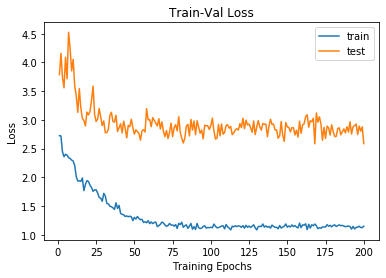

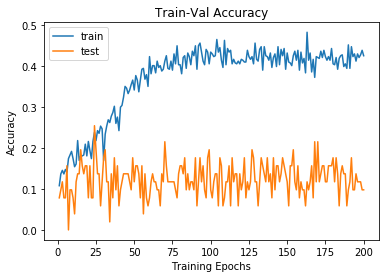

In [20]:
trainutils.plot_loss(loss_hist, metric_hist)